# Industry energy demand

### Import necessary modules

In [1]:
# Check if we are running the notebook directly, if so move workspace to parent dir
import sys
import os
currentdir = os.path.abspath(os.getcwd())
if os.path.basename(currentdir) != 'EDeMOS':  
  sys.path.insert(0, os.path.dirname(currentdir))
  os.chdir('..')
  print(f'Move to {os.getcwd()}')

Move to C:\Users\amillot\PycharmProjects\EDeMOS


In [2]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd

# Spatial
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPoint
from pyproj import CRS
from rasterstats import zonal_stats

# Plot
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib_scalebar.scalebar import ScaleBar

In [3]:
import config
from utils import processing_raster, finalizing_rasters, spatialjoinvectors
from Industry import energy_per_site
from Industry.data_loader import load_initial_data, load_and_process_energy_balance

INFO: Successfully loaded configuration for Zambia from config.py.


In [4]:
from plotting import plot_sector_consumption_map, plot_mining_process_breakdown

In [5]:
pd.options.display.float_format = '{:,.4f}'.format

### Import admin layers

In [6]:
regions_list, admin_gdf, region_gdf, grid, hexagons = load_initial_data(config)

Loading initial data...
Admin boundaries loaded. Country GDF: (1, 3), Region GDF: (10, 12)
Hexagon grid loaded: (122901, 10)


# Part 1. Extract GIS-based attributes

## Extract information from vector layers

Assess the energy consumption per site

In [7]:
## Running the energy calculation function 
from Industry import energy_per_site

energy_per_site.calc_energy_per_site(config)

USGS Targets for 2019 -> Ore: 799900.0, Metal: 782900.0
Loaded 1 known production values from Additional Info.
Production at a site  Fitwaola Open Pit Mine  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Production at a site  Fitwaola Open Pit Mine  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Production at a site  Mkushi Heap Leach  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Production at a site  Mufulira West Heap-Leach Facility  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Production at a site  TD3a, TD3b, TD5, and TD7 Tailings Dams  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Known Production (Fixed) -> Ore: 142021.35922330097, Metal: 0.0
Remaining USGS Target -> Ore: 657878.6407766991, Metal: 782900.0
Remaining Capacity

Extract sum production of mines in each cluster (hex)

In [8]:
grid, mines = spatialjoinvectors(config.COL_IND_ELEC_TJ, admin_gdf, config.CRS_WGS84, grid, "sum", config.MINES_OUTPUT_GPKG)
grid, mines_data = spatialjoinvectors(config.COL_IND_COPPER_ELEC_TJ, admin_gdf, config.CRS_WGS84, grid, "sum", config.MINES_OUTPUT_GPKG)

CRS matched successfully for points_correct.
CRS matched successfully for points_correct.


In [9]:
grid[config.COL_IND_ELEC_TJ].sum()

np.float64(18815.262062241934)

In [10]:
grid[config.COL_IND_COPPER_ELEC_TJ].sum()

np.float64(16351.791140741934)

In [11]:
grid.head(2)

,h3_index,n0,n1,n2,n3,n4,n5,NAME_1,id,geometry,ind_elec_TJ,copper_elec_TJ
0,87961a356ffffff,37613,59082,"12,565.0000","105,440.0000","84,210.0000","50,120.0000",Luapula,1,"POLYGON ((28.81003 -9.0957, 28.7975 -9.10199, ...",NaN,NaN
1,879621a75ffffff,60006,63712,"109,565.0000","6,805.0000","54,682.0000","68,091.0000",Southern,2,"POLYGON ((27.75779 -16.57852, 27.74484 -16.584...",NaN,NaN


In [12]:
mines.head(2)

,Country,FeatureNam,DsgAttr02,DsgAttr03,DsgAttr06,MemoOther,MemoLoc,Latitude,Longitude,DsgAttr07,...,ind_elec_TJ,ind_diesel_TJ,Elec_Step_Mining_TJ,Elec_Step_Milling_TJ,Elec_Step_Smelting_TJ,Elec_Step_Refining_TJ,Elec_Step_Leaching_EW_TJ,copper_elec_TJ,id,geometry
0,Zambia,Baluba Center Underground Mine,Copper,Concentrate,2017,Ore. Operations suspended. Facility on care-an...,<null>,-13.0486,28.3381,"1,500,000.0000",...,141.3952,25.8723,25.8723,115.5229,0.0000,0.0000,0.0000,141.3952,1,POINT (28.33806 -13.04861)
1,Zambia,Bwana Mkubwa Solvent Extraction-Electrowinning...,Copper,Metal,2017,Copper cathode.,<null>,-13.0423,28.7094,"52,000.0000",...,295.8502,152.4224,0.0000,0.0000,0.0000,0.0000,295.8502,295.8502,2,POINT (28.70935 -13.0423)


# Part 2. Compute demand

In [13]:
un_energy_data = load_and_process_energy_balance(config)

Loading and processing energy balance data...
Energy balance data processed. UN stats:
elec_nonFerrousMetals_TJ: 22,897.0 TJ
elec_mining_TJ: 818.0 TJ
oil_nonFerrousMetals_TJ: 1,191.1 TJ
oil_mining_TJ: 2,689.7 TJ
elec_ind_TJ: 23,715.0 TJ
oil_ind_TJ: 3,880.8 TJ
energy_ind_TJ: 27,595.8 TJ


In [14]:
elec_mining_consum = mines[mines["Output type (ass.)"].isin(["Ore and concentrate", "Metal in ore"])][config.COL_IND_ELEC_TJ].sum()

In [15]:
# Assess total energy consumption and total production
total_elec_consum = mines[config.COL_IND_ELEC_TJ].sum() # total
total_oil_consum = mines[config.COL_IND_OIL_TJ].sum() # total
total_energy_consum = total_elec_consum + total_oil_consum

coverage_energy_nonFe_mining = total_energy_consum / un_energy_data['energy_ind_TJ'] if un_energy_data['energy_ind_TJ'] else 0
coverage_elec_nonFe_mining = total_elec_consum / un_energy_data['elec_ind_TJ'] if un_energy_data['elec_ind_TJ'] else 0
coverage_oil_nonFe_mining = total_oil_consum / un_energy_data['oil_ind_TJ'] if un_energy_data['oil_ind_TJ'] else 0

mines_mining = mines[mines["Output type (ass.)"].isin(["Ore and concentrate", "Metal in ore"])]
elec_mining_consum = mines_mining[config.COL_IND_ELEC_TJ].sum()
oil_mining_consum = mines_mining[config.COL_IND_OIL_TJ].sum()
mines_nonFerrous = mines[mines["Output type (ass.)"].isin(["Metal"])]
elec_nonFerrousMetals_consum = mines_nonFerrous[config.COL_IND_ELEC_TJ].sum()
oil_nonFerrousMetals_consum = mines_nonFerrous[config.COL_IND_OIL_TJ].sum()

# print("total production:", f"{total_production/10**3:,.0f}", "kt")
print("total calculated electricity", f"{total_elec_consum:,.1f}",
      "TJ (mining: ", f"{elec_mining_consum:,.1f}",", non-Fe:",f"{elec_nonFerrousMetals_consum:,.1f}", ")")
print("total calculated diesel", f"{total_oil_consum:,.1f}",
      "TJ (mining: ",f"{oil_mining_consum:,.1f}",", non-Fe:",f"{oil_nonFerrousMetals_consum:,.1f}", ")")
print("total calculated energy consumption:", f"{total_energy_consum:,.1f}", "TJ")
print("----------------------------------------------------------------------------------------")
print("Coverage energy in statistical nonFerrousMetals and mining consumption:", f"{coverage_energy_nonFe_mining*100:,.0f}", "%")
print("----------------------------------------------------------------------------------------")
print("Coverage electricity in statistical nonFerrousMetals and mining consumption:", f"{coverage_elec_nonFe_mining*100:,.0f}", "%")
print("Coverage fuel/oil in statistical nonFerrousMetals and mining consumption:", f"{coverage_oil_nonFe_mining*100:,.0f}", "%")
print("----------------------------------------------------------------------------------------")
print("Coverage electricity in statistical mining consumption:", f"{elec_mining_consum/un_energy_data['elec_ind_TJ']*100:,.0f}", "%")
print("Coverage fuel/oil in statistical mining consumption:", f"{oil_mining_consum/un_energy_data['oil_ind_TJ']*100:,.0f}", "%")
print("Coverage electricity in statistical nonFerrousMetals consumption:", f"{elec_nonFerrousMetals_consum/un_energy_data['elec_nonFerrousMetals_TJ']*100:,.0f}", "%")
print("Coverage fuel/oil in statistical nonFerrousMetals consumption:", f"{oil_nonFerrousMetals_consum/un_energy_data['oil_nonFerrousMetals_TJ']*100:,.0f}", "%")

total calculated electricity 18,815.3 TJ (mining:  9,409.4 , non-Fe: 9,405.9 )
total calculated diesel 8,940.0 TJ (mining:  4,158.3 , non-Fe: 4,781.7 )
total calculated energy consumption: 27,755.2 TJ
----------------------------------------------------------------------------------------
Coverage energy in statistical nonFerrousMetals and mining consumption: 101 %
----------------------------------------------------------------------------------------
Coverage electricity in statistical nonFerrousMetals and mining consumption: 79 %
Coverage fuel/oil in statistical nonFerrousMetals and mining consumption: 230 %
----------------------------------------------------------------------------------------
Coverage electricity in statistical mining consumption: 40 %
Coverage fuel/oil in statistical mining consumption: 107 %
Coverage electricity in statistical nonFerrousMetals consumption: 41 %
Coverage fuel/oil in statistical nonFerrousMetals consumption: 401 %


In [16]:
# Allocate to each hexagon the industry energy consumption
# adjust energy consumption if coverage is the whole country
if config.AREA_OF_INTEREST == "COUNTRY":
    grid[config.COL_IND_ELEC_SCALED_TJ]=grid[config.COL_IND_ELEC_TJ]/coverage_elec_nonFe_mining  # TJ
else:
    grid[config.COL_IND_ELEC_SCALED_TJ]=grid[config.COL_IND_ELEC_TJ] # TJ
grid.head(3)

,h3_index,n0,n1,n2,n3,n4,n5,NAME_1,id,geometry,ind_elec_TJ,copper_elec_TJ,ind_elec_scaled_TJ
0,87961a356ffffff,37613,59082,"12,565.0000","105,440.0000","84,210.0000","50,120.0000",Luapula,1,"POLYGON ((28.81003 -9.0957, 28.7975 -9.10199, ...",NaN,NaN,NaN
1,879621a75ffffff,60006,63712,"109,565.0000","6,805.0000","54,682.0000","68,091.0000",Southern,2,"POLYGON ((27.75779 -16.57852, 27.74484 -16.584...",NaN,NaN,NaN
2,87975ed33ffffff,33164,91755,"45,750.0000","82,245.0000","5,988.0000","119,729.0000",Southern,3,"POLYGON ((25.67683 -17.43042, 25.66383 -17.436...",NaN,NaN,NaN


In [17]:
total_industry_electricity_beforescaling_tj = grid[config.COL_IND_ELEC_TJ].sum()
total_industry_electricity_afterscaling_tj = grid[config.COL_IND_ELEC_SCALED_TJ].sum()
print("Industry electricity consumption before scaling in",f"{config.AREA_OF_INTEREST}", ":",f"{total_industry_electricity_beforescaling_tj/3600:,.2f}", "TWh")
print("Industry electricity consumption after scaling in",f"{config.AREA_OF_INTEREST}", ":",f"{total_industry_electricity_afterscaling_tj/3600:,.2f}", "TWh")
print("Industry UN stats electricity consumption in",f"{config.AREA_OF_INTEREST}", ":",f"{un_energy_data['elec_ind_TJ']/3600:,.2f}", "TWh")

Industry electricity consumption before scaling in COUNTRY : 5.23 TWh
Industry electricity consumption after scaling in COUNTRY : 6.59 TWh
Industry UN stats electricity consumption in COUNTRY : 6.59 TWh


In [18]:
# grid.to_file(config.INDUSTRY_SHP_FILE, index=False)
# grid.to_file(config.INDUSTRY_GEOJSON_FILE, driver='GeoJSON', index=False)  
grid.to_file(config.INDUSTRY_GPKG_FILE, layer="mines", driver="GPKG", mode='w')
grid.head(3)

,h3_index,n0,n1,n2,n3,n4,n5,NAME_1,id,geometry,ind_elec_TJ,copper_elec_TJ,ind_elec_scaled_TJ
0,87961a356ffffff,37613,59082,"12,565.0000","105,440.0000","84,210.0000","50,120.0000",Luapula,1,"POLYGON ((28.81003 -9.0957, 28.7975 -9.10199, ...",NaN,NaN,NaN
1,879621a75ffffff,60006,63712,"109,565.0000","6,805.0000","54,682.0000","68,091.0000",Southern,2,"POLYGON ((27.75779 -16.57852, 27.74484 -16.584...",NaN,NaN,NaN
2,87975ed33ffffff,33164,91755,"45,750.0000","82,245.0000","5,988.0000","119,729.0000",Southern,3,"POLYGON ((25.67683 -17.43042, 25.66383 -17.436...",NaN,NaN,NaN


# Part 3: Industry mapping

In [19]:
# Retrieve copper values and convert in GWh
grid['Copper_elec_GWh'] = grid[config.COL_IND_COPPER_ELEC_TJ] / 3.6
totalperregion=grid.groupby(config.ADMIN_REGION_COLUMN_NAME)['Copper_elec_GWh'].sum()
grid['total_copper_elec_perregion_GWh'] = grid[config.ADMIN_REGION_COLUMN_NAME].map(totalperregion)
totalperregion

NAME_1
Central            22.1255
Copperbelt      2,510.3205
Eastern             0.0000
Luapula             0.0000
Lusaka              0.0000
Muchinga            0.0000
North-Western   2,005.3965
Northern            0.0000
Southern            4.3217
Western             0.0000
Name: Copper_elec_GWh, dtype: float64

In [20]:
grid_filtered = grid[grid[config.ADMIN_REGION_COLUMN_NAME] == 'Copperbelt']
region_gdf_filtered = region_gdf[region_gdf[config.ADMIN_REGION_COLUMN_NAME] == 'Copperbelt']
hexagons_filtered = hexagons[hexagons[config.ADMIN_REGION_COLUMN_NAME] == 'Copperbelt']

Plotting Copper Consumption map...


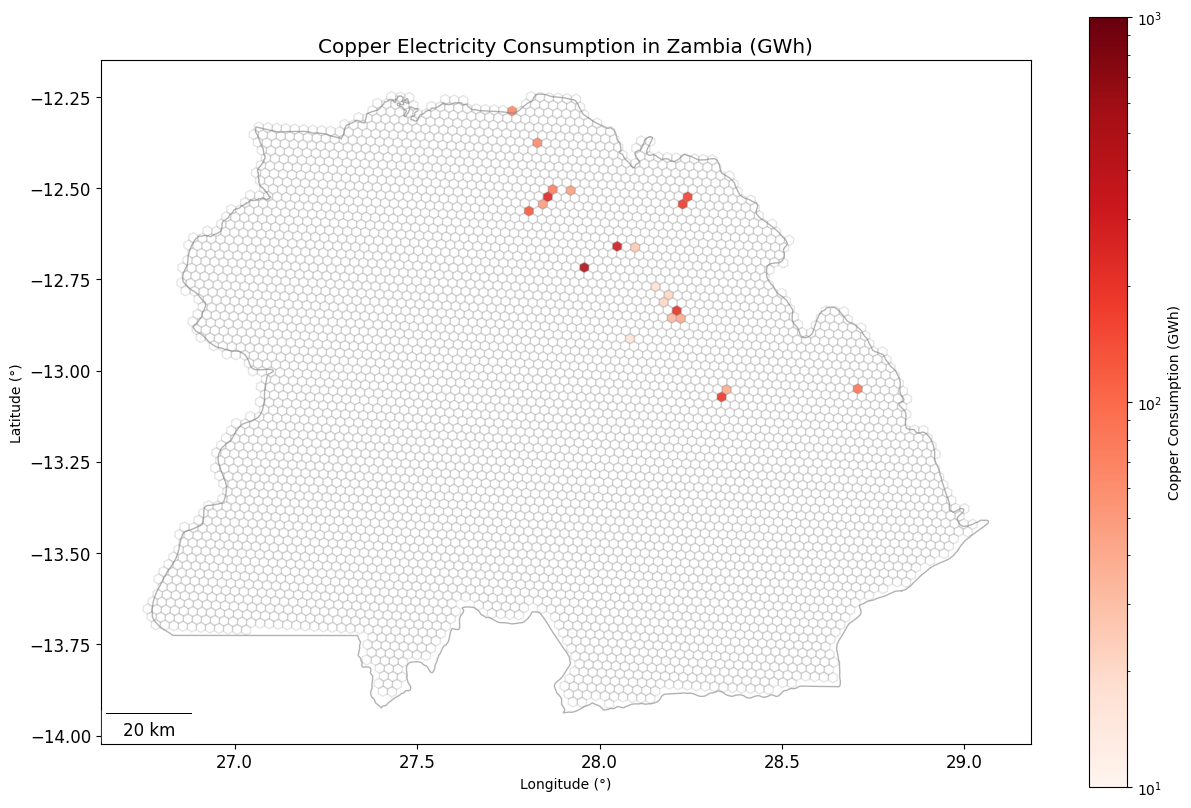

In [21]:
plot_sector_consumption_map(grid_filtered, 'Copper_elec_GWh', config, region_gdf_filtered, hexagons_filtered, 'Copper',
                           lines_gdf=None, fig_size=(15, 10))

Plotting Copper Region Consumption map...


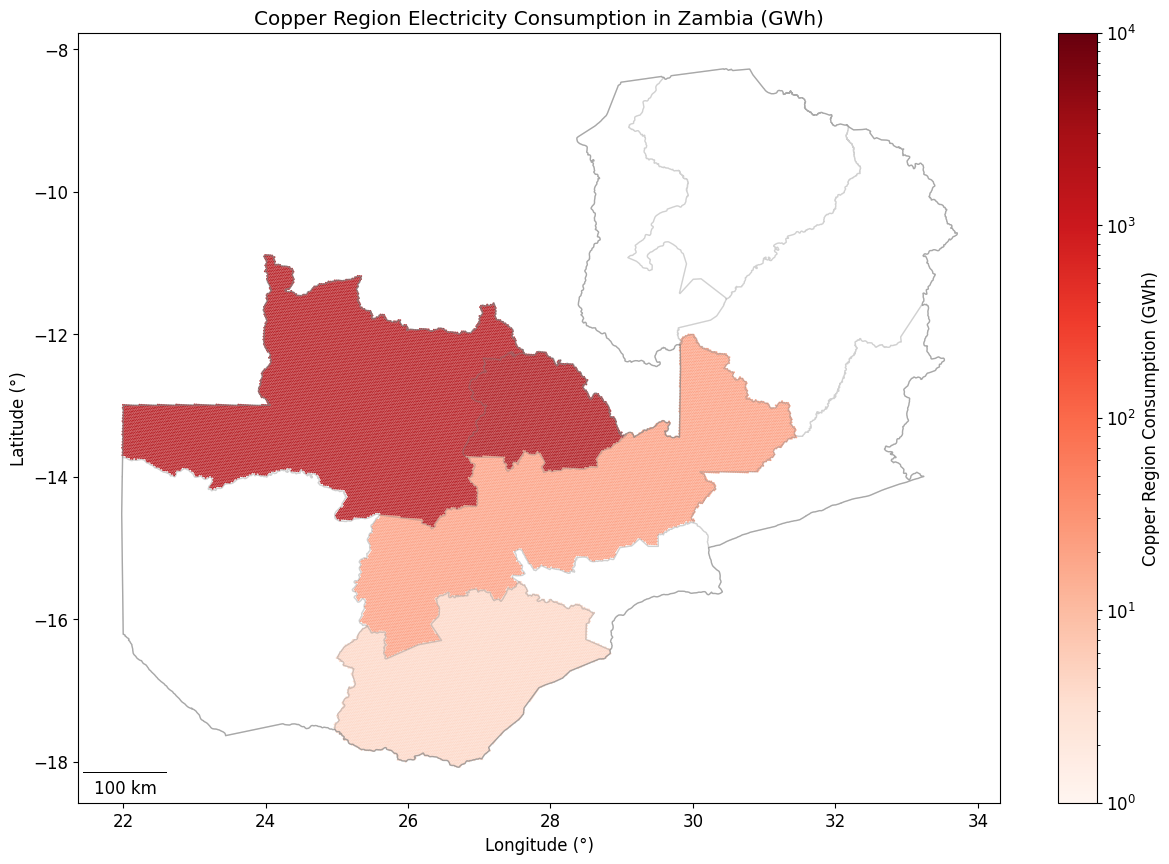

In [22]:
plot_sector_consumption_map(grid, 'total_copper_elec_perregion_GWh', config, admin_gdf, region_gdf, 'Copper Region',
                           lines_gdf=None, fig_size=(15, 10))

Plotting Industry Consumption map...


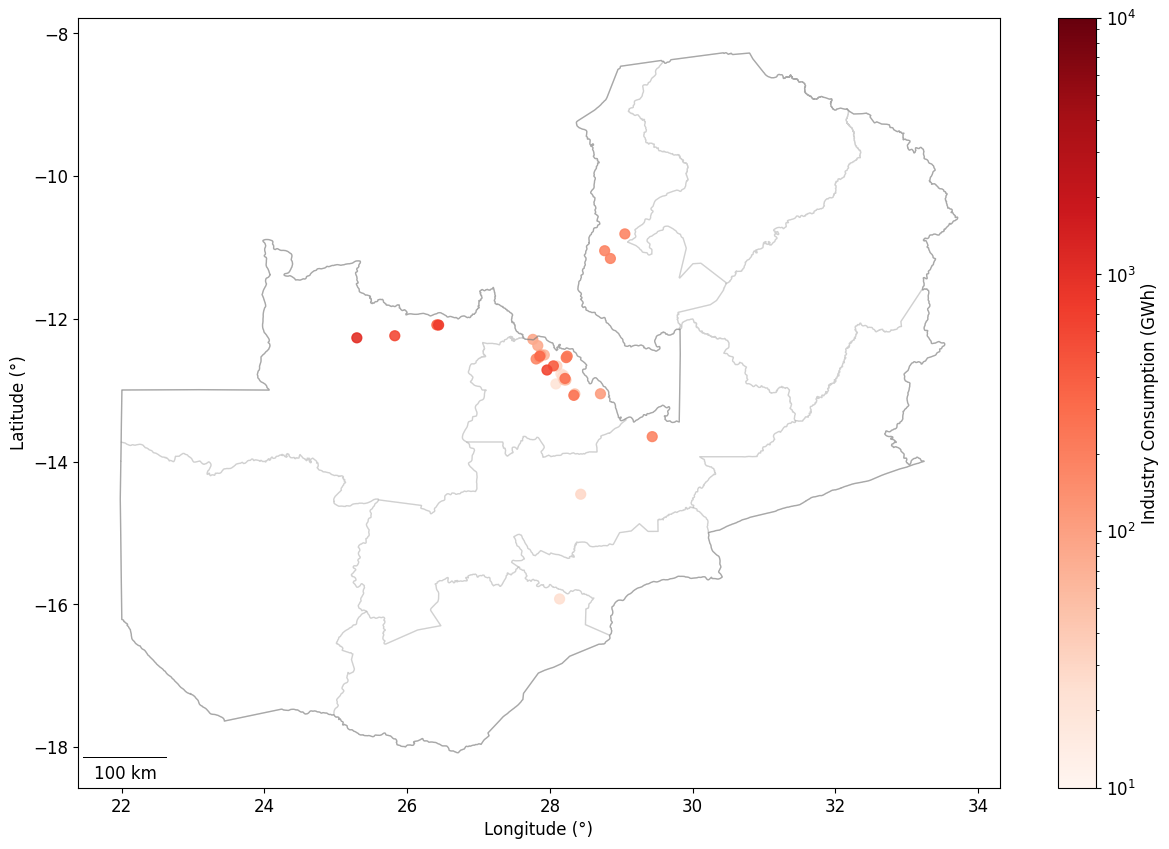

In [23]:
grid[config.COL_IND_ELEC_GWH]=grid[config.COL_IND_ELEC_SCALED_TJ]/3.6
plot_sector_consumption_map(grid, config.COL_IND_ELEC_GWH, config, admin_gdf, region_gdf, 'Industry', lines_gdf=None, 
                           fig_size=(15, 10), title = False, plot_as_dots=True)

Share of Industrial Electricity Consumption by Process Step
(Total Modeled: 5.23 TWh)


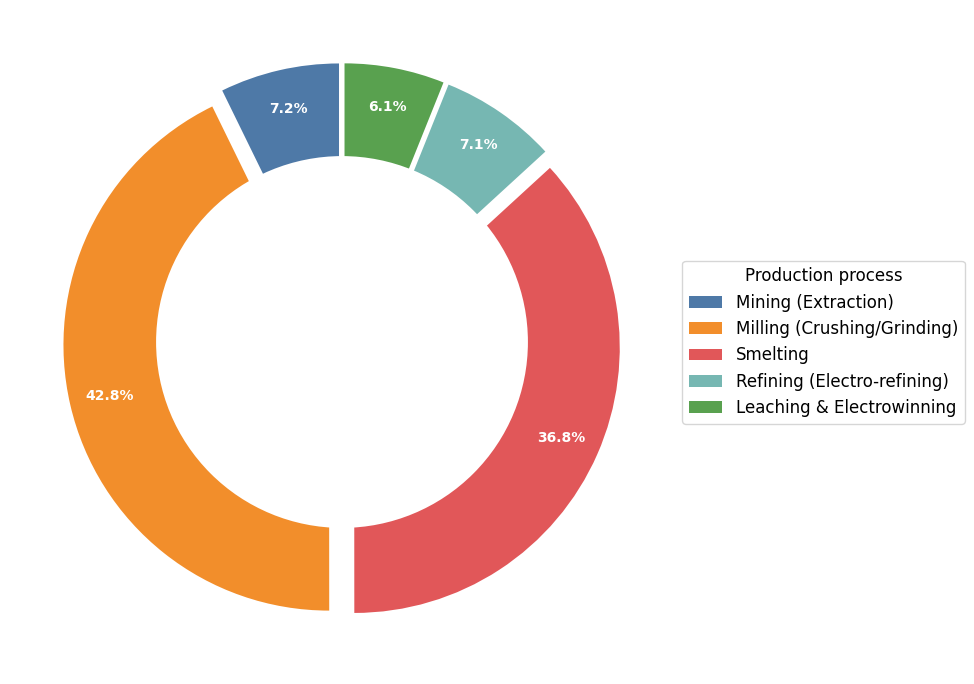

In [24]:
plot_mining_process_breakdown(config)